The code loads an Excel file into a pandas DataFrame and assigns a fixed price per square meter for Warsaw. It then fills missing values in the cena_za_metr_kw and metraz columns with their respective means. After displaying the first few rows, it creates two new columns (PPMS and metrage) as duplicates of existing ones (for better redability with the report).

In [25]:
import pandas as pd
import numpy as np
import os
import time
import psutil
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pprint import pprint 

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim


# Data preparation
df=pd.read_excel('filtered_results2_with_rating.xlsx')

df['cena_wwa']=  15504.43164

# Filling missing values
df.loc[pd.isna(df['cena_za_metr_kw']), 'cena_za_metr_kw'] = df['cena_za_metr_kw'].mean()
df.loc[pd.isna(df['metraz']), 'metraz'] = df['metraz'].mean()
print(df.head())
df['PPMS'] = df['cena_za_metr_kw']
df['metrage'] = df['metraz']
df = pd.DataFrame(df)

      cena  cena_za_metr_kw  \
0  1380000          15862.0   
1   799000          17109.0   
2   667000          18992.0   
3  1289000          13713.0   
4   898379          16499.0   

                                         lokalizacja  liczba_pokoi  metraz  \
0  Szeligowska, Chrzanów, Bemowo, Warszawa, mazow...             4   87.00   
1  Szeligowska, Chrzanów, Bemowo, Warszawa, mazow...             2   46.70   
2  Szeligowska, Chrzanów, Bemowo, Warszawa, mazow...             2   35.12   
3  Podgrodzie, Chrzanów, Bemowo, Warszawa, mazowi...             3   94.00   
4  Szeligowska, Chrzanów, Bemowo, Warszawa, mazow...             3   54.45   

  stan_wykonczenia      rynek  rok_budowy winda  \
0   do wykończenia  pierwotny      2026.0   tak   
1   do wykończenia  pierwotny      2024.0   tak   
2   do wykończenia  pierwotny      2025.0   tak   
3  do zamieszkania  pierwotny      2027.0   tak   
4   do wykończenia  pierwotny         NaN   tak   

                Współrzędne Geografic

C:\Users\wojte\AppData\Local\Temp\ipykernel_10788\1992406280.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17233.415877640204' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[pd.isna(df['cena_za_metr_kw']), 'cena_za_metr_kw'] = df['cena_za_metr_kw'].mean()


The code assigns numerical codes to Warsaw districts based on the lokalizacja column, ensuring case-insensitive matching. If a district is not found, it defaults to 0. Missing values in rok_budowy are replaced with 2025. The binary_encode function converts categorical "yes/no" values into binary format, with missing values in standard_encoded set to 0. Unnecessary columns related to location and amenities are dropped, and the processed DataFrame is displayed.

In [26]:
def encode_location(lokalizacja):
    if pd.isna(lokalizacja) or not isinstance(lokalizacja, str):
        return 0

    location_codes = {
        'bemowo': 2,
        'wola': 10,
        'ochota': 5,
        'mokotów': 8,
        'ursynów': 6,
        'wilanów': 7,
        'śródmieście': 11,
        'praga-południe': 4,
        'praga-północ': 12,
        'ursus': 13,
        "białołęka": 14,
        "wawer": 15,
        "wesoła": 16,
        "rembertów": 17,
        "włochy": 18,
        'targówek': 1,
        'bielany': 3,
        'żoliborz': 9,
    }
    
    # Converting to lowercase for case-insensitive matching
    location_lower = lokalizacja.lower()
    
    for pattern, code in location_codes.items():
        if pattern in location_lower:
            return code
    
    # Returning 0 if no match found
    return 0

# Applying location encoding
df['District_code'] = df['lokalizacja'].apply(encode_location)

# Fililng missing rok budowy, although it is not used in the model - just to avoid NaNs
df.loc[pd.isna(df['rok_budowy']), 'rok_budowy'] = 2025

# Binary encoding for yes/no column
def binary_encode(series, positive_value='TAK'):
    "Converting yes/no column to binary (1/0) - value to consider as 1 (default 'TAK')"

    # Filling NaN with a default value (0)
    return (series == positive_value).astype(int)

# Applying binary encoding to lift, stan_wykonczenia columns
df['lift_encoded'] = binary_encode(df['winda'])
df['standard_encoded'] = binary_encode(df['stan_wykonczenia'], positive_value='do wykonczenia')
df.loc[pd.isna(df['standard_encoded']), 'standard_encoded'] = 0
# droping columns not used in the model
df.drop(columns=['winda','lokalizacja','stan_wykonczenia','rynek','rok_budowy','Współrzędne Geograficzne','x','y','geometry'\
                 ,'Sklep','Galerie handlowe','Przychodnia','Szpitale','Apteki','Urzędy','Kino','Teatr','Plac zabaw','Dworzec główny','Starówka'\
                    ,'Przystanek Metro','Przystanek Autobusowy','Przystanek Tramwajowy','Przedszkola','Szkoły Podstawowe','Licea','Uniwersytety','Parki','Siłownie'\
                        ,'Basen','Kościoły','Poczta'], inplace=True)

print("\nProcessed DataFrame:")
print(df.head())


Processed DataFrame:
      cena  cena_za_metr_kw  liczba_pokoi  metraz    rating     cena_wwa  \
0  1380000          15862.0             4   87.00  0.001973  15504.43164   
1   799000          17109.0             2   46.70  0.001973  15504.43164   
2   667000          18992.0             2   35.12  0.001973  15504.43164   
3  1289000          13713.0             3   94.00  0.000664  15504.43164   
4   898379          16499.0             3   54.45  0.001973  15504.43164   

      PPMS  metrage  District_code  lift_encoded  standard_encoded  
0  15862.0    87.00              2             0                 0  
1  17109.0    46.70              2             0                 0  
2  18992.0    35.12              2             0                 0  
3  13713.0    94.00              2             0                 0  
4  16499.0    54.45              2             0                 0  


Dictionary mapping of district codes to their respective price per square meter. Applying a function that assigns the corresponding price based on the District_code column, defaulting to 15,504.43 if the district is not found. The computed values are stored in the price_per_sqm_loc column.

In [27]:
# Dictionary mapping location codes to price per square meter
price_per_sqm = {
    2: 17973.318,  # Bemowo
    10: 27517.467, # Wola
    5: 21390.504,  # Ochota
    8: 22210.838,  # Mokotów
    6: 20161.402,  # Ursynów
    7: 19061.205,  # Wilanów
    11: 30347.383, # Śródmieście
    4: 18747.615,  # Praga - Południe
    12: 19445.91,  # Praga - Północ
    13: 14344.761,  # Ursus
    14: 13407.166,  # Białołęka
    15: 12874.265,  # Wawer
    16: 14334.417,  # Wesoła
    17: 14367.94,  # Rembertów
    18: 17192.117,  # Włochy
    1: 15756.737,  # Targówek
    3: 18994.662,  # Bielany
    9: 25929.404  # Żoliborz

}

# Assigning price per square meter based on location code
def assign_price_per_sqm(encoded_location):
    return price_per_sqm.get(encoded_location, 15504.43)  

# Applying price per square meter assignment
df['price_per_sqm_loc'] = df['District_code'].apply(assign_price_per_sqm)

print("\nProcessed DataFrame with Price per sqm:")
print(df.head())



Processed DataFrame with Price per sqm:
      cena  cena_za_metr_kw  liczba_pokoi  metraz    rating     cena_wwa  \
0  1380000          15862.0             4   87.00  0.001973  15504.43164   
1   799000          17109.0             2   46.70  0.001973  15504.43164   
2   667000          18992.0             2   35.12  0.001973  15504.43164   
3  1289000          13713.0             3   94.00  0.000664  15504.43164   
4   898379          16499.0             3   54.45  0.001973  15504.43164   

      PPMS  metrage  District_code  lift_encoded  standard_encoded  \
0  15862.0    87.00              2             0                 0   
1  17109.0    46.70              2             0                 0   
2  18992.0    35.12              2             0                 0   
3  13713.0    94.00              2             0                 0   
4  16499.0    54.45              2             0                 0   

   price_per_sqm_loc  
0          17973.318  
1          17973.318  
2          1

Clustering analysis on real estate data using K-Means and Hierarchical Clustering. Standardizing numerical features (PPMS, metrage, and rating), spliting the dataset into training (60%) and test (40%) sets, and applying both clustering methods. Hierarchical clustering uses Ward’s method to generate a dendrogram, while the optimal number of clusters for K-Means is determined via the Elbow Method. The chosen k is then applied to segment the training data, and the test data is assigned clusters based on K-Means centroids. Performance metrics, including execution time, memory usage, and CPU load, are logged throughout.


----- Performance Metrics: Train-Test Split and Scaling -----
Execution Time: 0.0041 seconds
Memory Usage: 515.88 MB → 515.88 MB (Increase: 0.00 MB)
CPU Usage: Initial 0.00%, Final 0.00%
--------------------------------------------------

----- Performance Metrics: Hierarchical Linkage Calculation -----
Execution Time: 0.0073 seconds
Memory Usage: 515.88 MB → 515.91 MB (Increase: 0.03 MB)
CPU Usage: Initial 0.00%, Final 0.00%
--------------------------------------------------


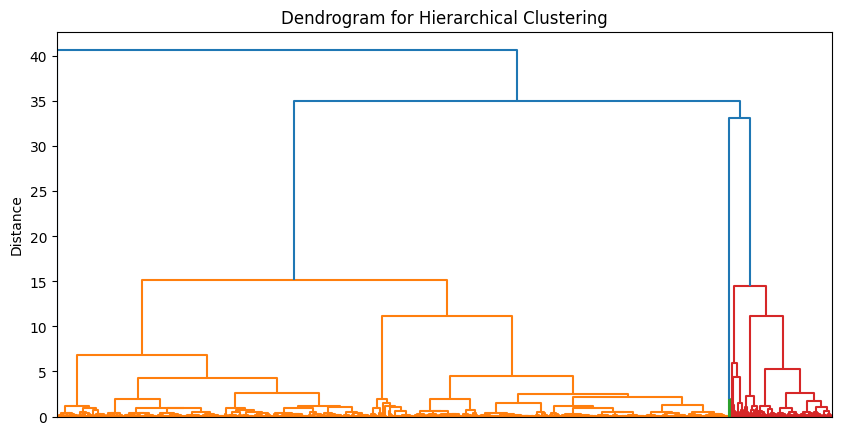


----- Performance Metrics: K-Means Elbow Method -----
Execution Time: 0.7661 seconds
Memory Usage: 520.70 MB → 521.26 MB (Increase: 0.55 MB)
CPU Usage: Initial 0.00%, Final 0.00%
--------------------------------------------------


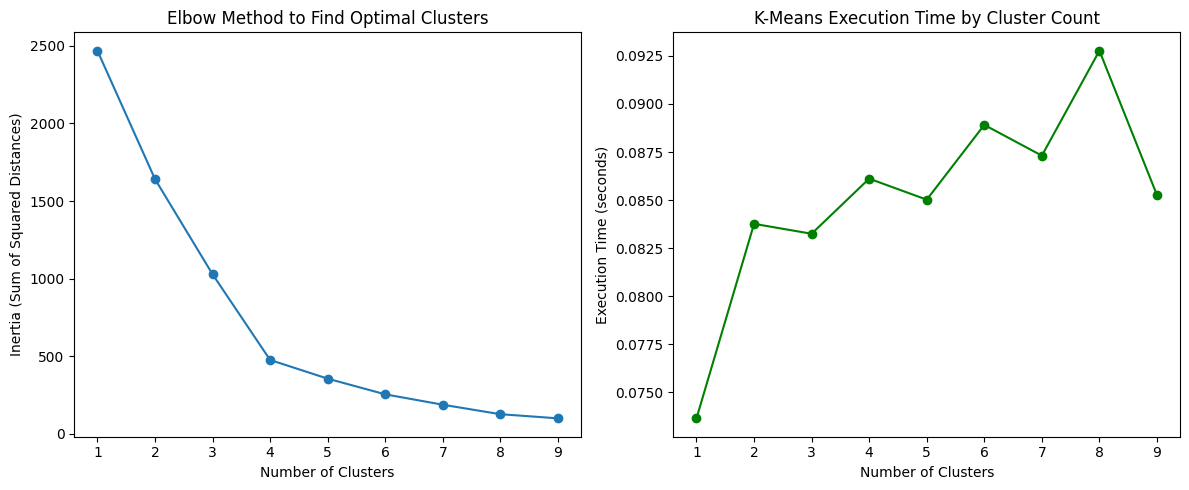


----- Performance Metrics: K-Means Clustering (Train Set) -----
Execution Time: 0.1017 seconds
Memory Usage: 524.16 MB → 524.23 MB (Increase: 0.07 MB)
CPU Usage: Initial 0.00%, Final 0.00%
--------------------------------------------------

----- Performance Metrics: Hierarchical Clustering (Train Set) -----
Execution Time: 0.0020 seconds
Memory Usage: 524.23 MB → 524.23 MB (Increase: 0.00 MB)
CPU Usage: Initial 0.00%, Final 0.00%
--------------------------------------------------

----- Performance Metrics: K-Means Prediction (Test Set) -----
Execution Time: 0.0047 seconds
Memory Usage: 524.23 MB → 524.08 MB (Increase: -0.15 MB)
CPU Usage: Initial 0.00%, Final 0.00%
--------------------------------------------------

----- Performance Metrics: TOTAL EXECUTION -----
Execution Time: 3.2620 seconds
Memory Usage: 515.88 MB → 524.09 MB (Increase: 8.21 MB)
CPU Usage: Initial 0.00%, Final 0.00%
--------------------------------------------------

----- PERFORMANCE SUMMARY -----
      Algorit

In [28]:
# setting seed value
seed_value = 55
np.random.seed(seed_value)

# Function to monitor resources
def get_process_metrics():
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Converting to MB
    cpu_percent = process.cpu_percent(interval=None)
    return memory_usage, cpu_percent

# Function to log performance metrics
def log_performance(description, start_time, end_time, start_memory, end_memory, start_cpu, end_cpu):
    execution_time = end_time - start_time
    memory_increase = end_memory - start_memory
    print(f"\n----- Performance Metrics: {description} -----")
    print(f"Execution Time: {execution_time:.4f} seconds")
    print(f"Memory Usage: {start_memory:.2f} MB → {end_memory:.2f} MB (Increase: {memory_increase:.2f} MB)")
    print(f"CPU Usage: Initial {start_cpu:.2f}%, Final {end_cpu:.2f}%")
    print("-" * 50)

# Numerical features for clustering
features = df[['PPMS', 'metrage','rating']]

# Resource usage
initial_memory, initial_cpu = get_process_metrics()
total_start_time = time.time()

# Standardizing features
start_time = time.time()
start_memory, start_cpu = get_process_metrics()

scaler = StandardScaler()

# Train-Test Split (60/40)
start_time = time.time()
start_memory, start_cpu = get_process_metrics()

train_data, test_data = train_test_split(df, test_size=0.4, random_state=42)

train_features = train_data[['PPMS', 'metrage', 'rating']]
scaler.fit(train_features)
train_scaled = scaler.transform(train_features)
test_scaled = scaler.transform(test_data[['PPMS', 'metrage', 'rating']])

end_time = time.time()
end_memory, end_cpu = get_process_metrics()
log_performance("Train-Test Split and Scaling", start_time, end_time, start_memory, end_memory, start_cpu, end_cpu)

# Dendogram
start_time = time.time()
start_memory, start_cpu = get_process_metrics()
linked = sch.linkage(train_scaled, method='ward')

end_time = time.time()
end_memory, end_cpu = get_process_metrics()
log_performance("Hierarchical Linkage Calculation", start_time, end_time, start_memory, end_memory, start_cpu, end_cpu)

# Dendrogram
plt.figure(figsize=(10, 5))
sch.dendrogram(linked)
plt.title("Dendrogram for Hierarchical Clustering")
plt.ylabel("Distance")
plt.xticks([])
plt.show()

# Optimal K - Elbow Method
start_time = time.time()
start_memory, start_cpu = get_process_metrics()

inertia = []
K_range = range(1, 10)  # k 1 - 10
kmeans_times = []

for k in K_range:
    k_start_time = time.time()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_scaled)
    k_end_time = time.time()
    kmeans_times.append(k_end_time - k_start_time)
    inertia.append(kmeans.inertia_)

end_time = time.time()
end_memory, end_cpu = get_process_metrics()
log_performance("K-Means Elbow Method", start_time, end_time, start_memory, end_memory, start_cpu, end_cpu)

# Elbow plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method to Find Optimal Clusters')

# Time plot
plt.subplot(1, 2, 2)
plt.plot(K_range, kmeans_times, marker='o', linestyle='-', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Execution Time (seconds)')
plt.title('K-Means Execution Time by Cluster Count')
plt.tight_layout()
plt.show()

# Input manual of K 
optimal_k = int(input("Enter the optimal number of clusters from the elbow graph: "))

# -K-Means Clustering
start_time = time.time()
start_memory, start_cpu = get_process_metrics()

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
train_data['KMeans_Cluster'] = kmeans.fit_predict(train_scaled)

end_time = time.time()
end_memory, end_cpu = get_process_metrics()
log_performance("K-Means Clustering (Train Set)", start_time, end_time, start_memory, end_memory, start_cpu, end_cpu)

# Hierarchical Clustering
start_time = time.time()
start_memory, start_cpu = get_process_metrics()

train_data['Hierarchical_Cluster'] = fcluster(linked, optimal_k, criterion='maxclust')

end_time = time.time()
end_memory, end_cpu = get_process_metrics()
log_performance("Hierarchical Clustering (Train Set)", start_time, end_time, start_memory, end_memory, start_cpu, end_cpu)

# Storing Clusters Separately
train_clusters = {}
for cluster_id in range(optimal_k):
    train_clusters[f"Train_Cluster_{cluster_id}"] = train_data[train_data['KMeans_Cluster'] == cluster_id]

# 
start_time = time.time()
start_memory, start_cpu = get_process_metrics()

test_data['KMeans_Cluster'] = kmeans.predict(test_scaled)

end_time = time.time()
end_memory, end_cpu = get_process_metrics()
log_performance("K-Means Prediction (Test Set)", start_time, end_time, start_memory, end_memory, start_cpu, end_cpu)

# Storing test clusters separately
test_clusters = {}
for cluster_id in range(optimal_k):
    test_clusters[f"Test_Cluster_{cluster_id}"] = test_data[test_data['KMeans_Cluster'] == cluster_id]

# Total exec time
total_end_time = time.time()
final_memory, final_cpu = get_process_metrics()
log_performance("TOTAL EXECUTION", total_start_time, total_end_time, initial_memory, final_memory, initial_cpu, final_cpu)

# Performance Summary
print("\n----- PERFORMANCE SUMMARY -----")
performance_data = {
    'Algorithm': ['K-Means', 'Hierarchical'],
    'Train Time (s)': [
        next(time for k, time in zip(K_range, kmeans_times) if k == optimal_k),
        end_time - start_time  # Hierarchical clustering time
    ],
    'Memory Usage (MB)': [
        end_memory - start_memory,  # Approximate memory usage
        end_memory - start_memory   # Approximate memory usage
    ],
    'CPU Usage (%)': [
        end_cpu,
        end_cpu
    ]
}
performance_df = pd.DataFrame(performance_data)
print(performance_df)
print("-" * 50)

# Clustering results
print("\nFirst 10 rows of TRAINING data with assigned clusters:")
print(train_data[['PPMS','liczba_pokoi', 'metrage','price_per_sqm_loc','standard_encoded','lift_encoded','cena_wwa','rating', 'KMeans_Cluster', 'Hierarchical_Cluster']].head(10))

print("\nFirst 10 rows of TEST data with assigned clusters:")
print(test_data[['PPMS','liczba_pokoi', 'metrage','price_per_sqm_loc','standard_encoded','lift_encoded','cena_wwa','rating', 'KMeans_Cluster']].head(10))

print("\nCluster Distribution in TRAINING Set (K-Means):")
print(train_data['KMeans_Cluster'].value_counts().sort_index())

print("\nCluster Distribution in TRAINING Set (Hierarchical Clustering):")
print(train_data['Hierarchical_Cluster'].value_counts().sort_index())

print("\nCluster Distribution in TEST Set (K-Means Assigned):")
print(test_data['KMeans_Cluster'].value_counts().sort_index())

Code for PCA analysis

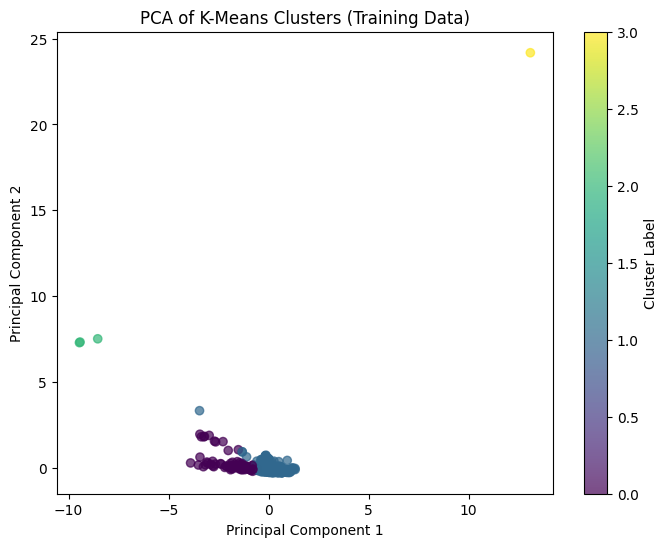

In [29]:
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1], 
                      c=train_data['KMeans_Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of K-Means Clusters (Training Data)')
plt.colorbar(scatter, label='Cluster Label')
plt.show()


Preprocess data, split it into training and test sets, and apply feature scaling. Train and evaluate Linear Regression (LR) first, followed by a 3-layer feedforward Neural Network (NN) + 2 activation layers with customizable activation functions and early stopping. Log and visualize performance metrics (MAE, MSE, MAPE, R², execution time, memory usage, CPU load). Analysis of results.


--- Processing Cluster 0 ---

--- Training Linear Regression for Cluster 0 ---
Linear Regression Evaluation Metrics for Cluster 0:
  MAE: 4732.6002
  MSE: 38419887.9812
  MAPE: 15.25%
  R² Score: 0.0531

----- Performance Metrics: Linear Regression (Cluster 0) -----
Execution Time: 0.0010 seconds
Memory Usage: 527.29 MB → 527.29 MB (Increase: 0.00 MB)
--------------------------------------------------

--- Training Feed Forward Neural Network for Cluster 0 ---
Cluster 0 - Epoch 1/50000, Loss: 963418496.0000
  Epoch Time: 0.0022s, Memory: 527.30MB
Cluster 0 - Epoch 101/50000, Loss: 962276800.0000
  Epoch Time: 0.0010s, Memory: 527.30MB
Cluster 0 - Epoch 201/50000, Loss: 953867328.0000
  Epoch Time: 0.0005s, Memory: 527.30MB
Cluster 0 - Epoch 301/50000, Loss: 929744320.0000
  Epoch Time: 0.0011s, Memory: 527.30MB
Cluster 0 - Epoch 401/50000, Loss: 881731968.0000
  Epoch Time: 0.0010s, Memory: 527.30MB
Cluster 0 - Epoch 501/50000, Loss: 801039872.0000
  Epoch Time: 0.0010s, Memory: 527.3

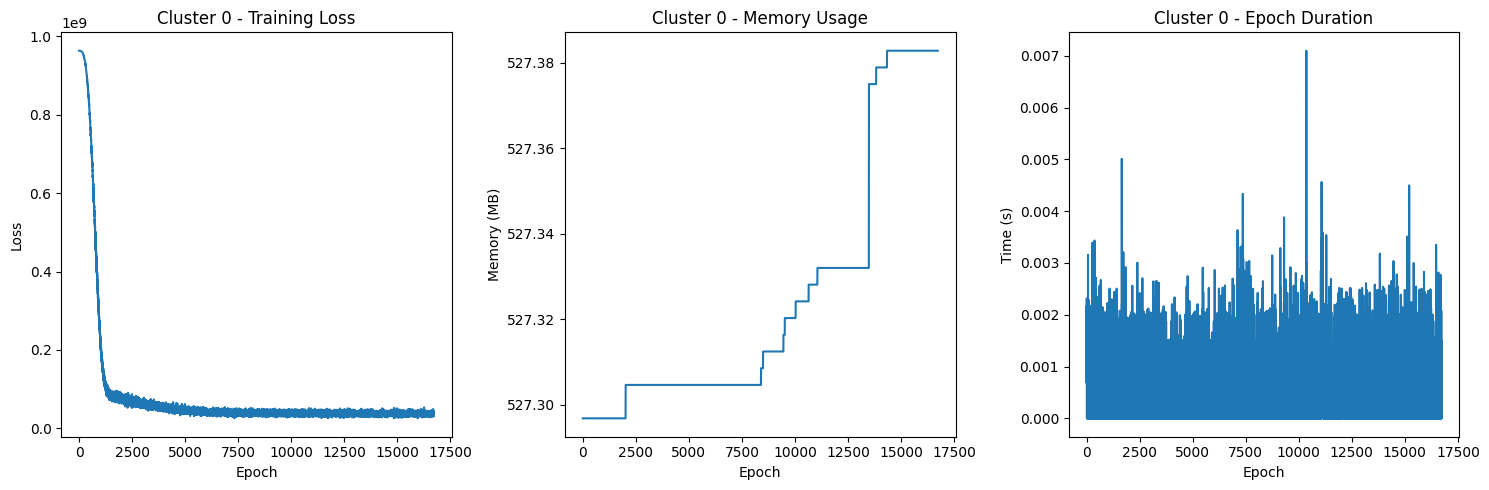


--- Processing Cluster 1 ---

--- Training Linear Regression for Cluster 1 ---
Linear Regression Evaluation Metrics for Cluster 1:
  MAE: 1426.5241
  MSE: 3890305.2241
  MAPE: 9.20%
  R² Score: 0.5580

----- Performance Metrics: Linear Regression (Cluster 1) -----
Execution Time: 0.0000 seconds
Memory Usage: 544.75 MB → 544.75 MB (Increase: 0.00 MB)
--------------------------------------------------

--- Training Feed Forward Neural Network for Cluster 1 ---
Cluster 1 - Epoch 1/50000, Loss: 246814512.0000
  Epoch Time: 0.0040s, Memory: 544.75MB
Cluster 1 - Epoch 101/50000, Loss: 246453680.0000
  Epoch Time: 0.0014s, Memory: 544.75MB
Cluster 1 - Epoch 201/50000, Loss: 243720816.0000
  Epoch Time: 0.0020s, Memory: 544.75MB
Cluster 1 - Epoch 301/50000, Loss: 235614560.0000
  Epoch Time: 0.0010s, Memory: 544.75MB
Cluster 1 - Epoch 401/50000, Loss: 220012112.0000
  Epoch Time: 0.0021s, Memory: 544.75MB
Cluster 1 - Epoch 501/50000, Loss: 195666960.0000
  Epoch Time: 0.0010s, Memory: 544.75M

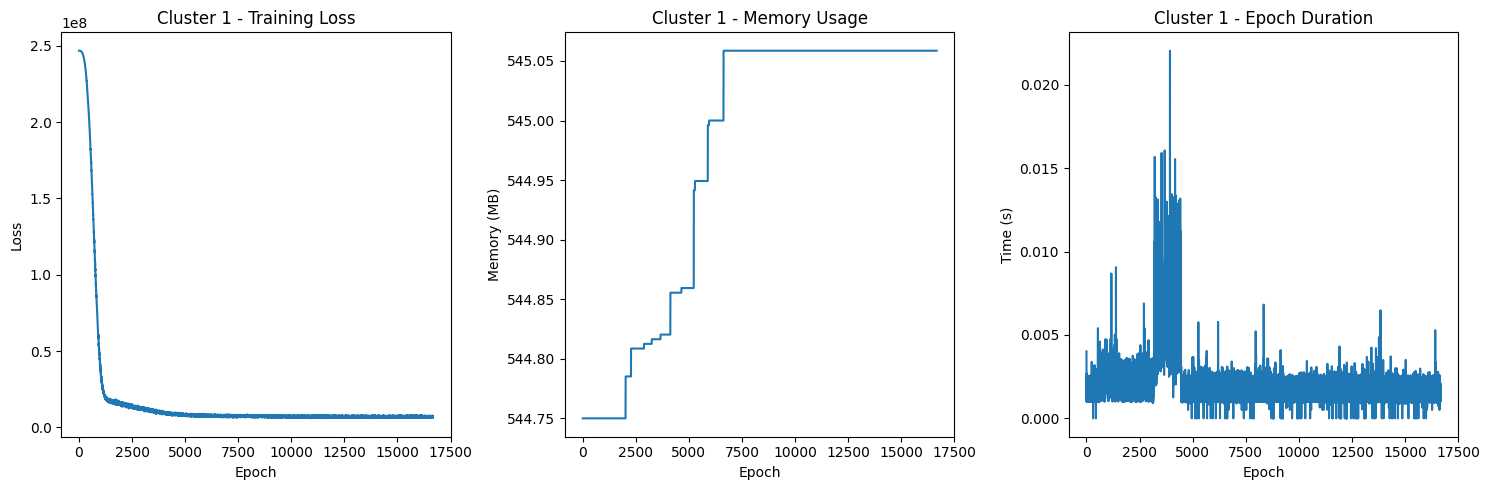


--- Processing Cluster 2 ---
Skipping Cluster 2 (Insufficient data).

--- Processing Cluster 3 ---
Skipping Cluster 3 (Insufficient data).

----- Performance Metrics: OVERALL EXECUTION -----
Execution Time: 51.6575 seconds
Memory Usage: 527.28 MB → 558.44 MB (Increase: 31.16 MB)
--------------------------------------------------

=== MODEL COMPARISON: LINEAR REGRESSION VS NEURAL NETWORK ===

--- Linear Regression Average Metrics Across All Clusters ---
  Average MAE: 3079.5622
  Average MSE: 21155096.6027
  Average MAPE (%): 12.2265
  Average R² Score: 0.3056

--- Neural Network Average Metrics Across All Clusters ---
  Average MAE: 3019.6232
  Average MSE: 21086228.2500
  Average MAPE (%): 11.8802
  Average R² Score: 0.3065

--- Performance Improvement (Neural Network vs Linear Regression) ---
  MAE: 1.95% reduction
  MSE: 0.33% reduction
  MAPE (%): 2.83% reduction
  R² Score: 0.30% improvement

=== DETAILED PERFORMANCE COMPARISON ===
                  training_time                 

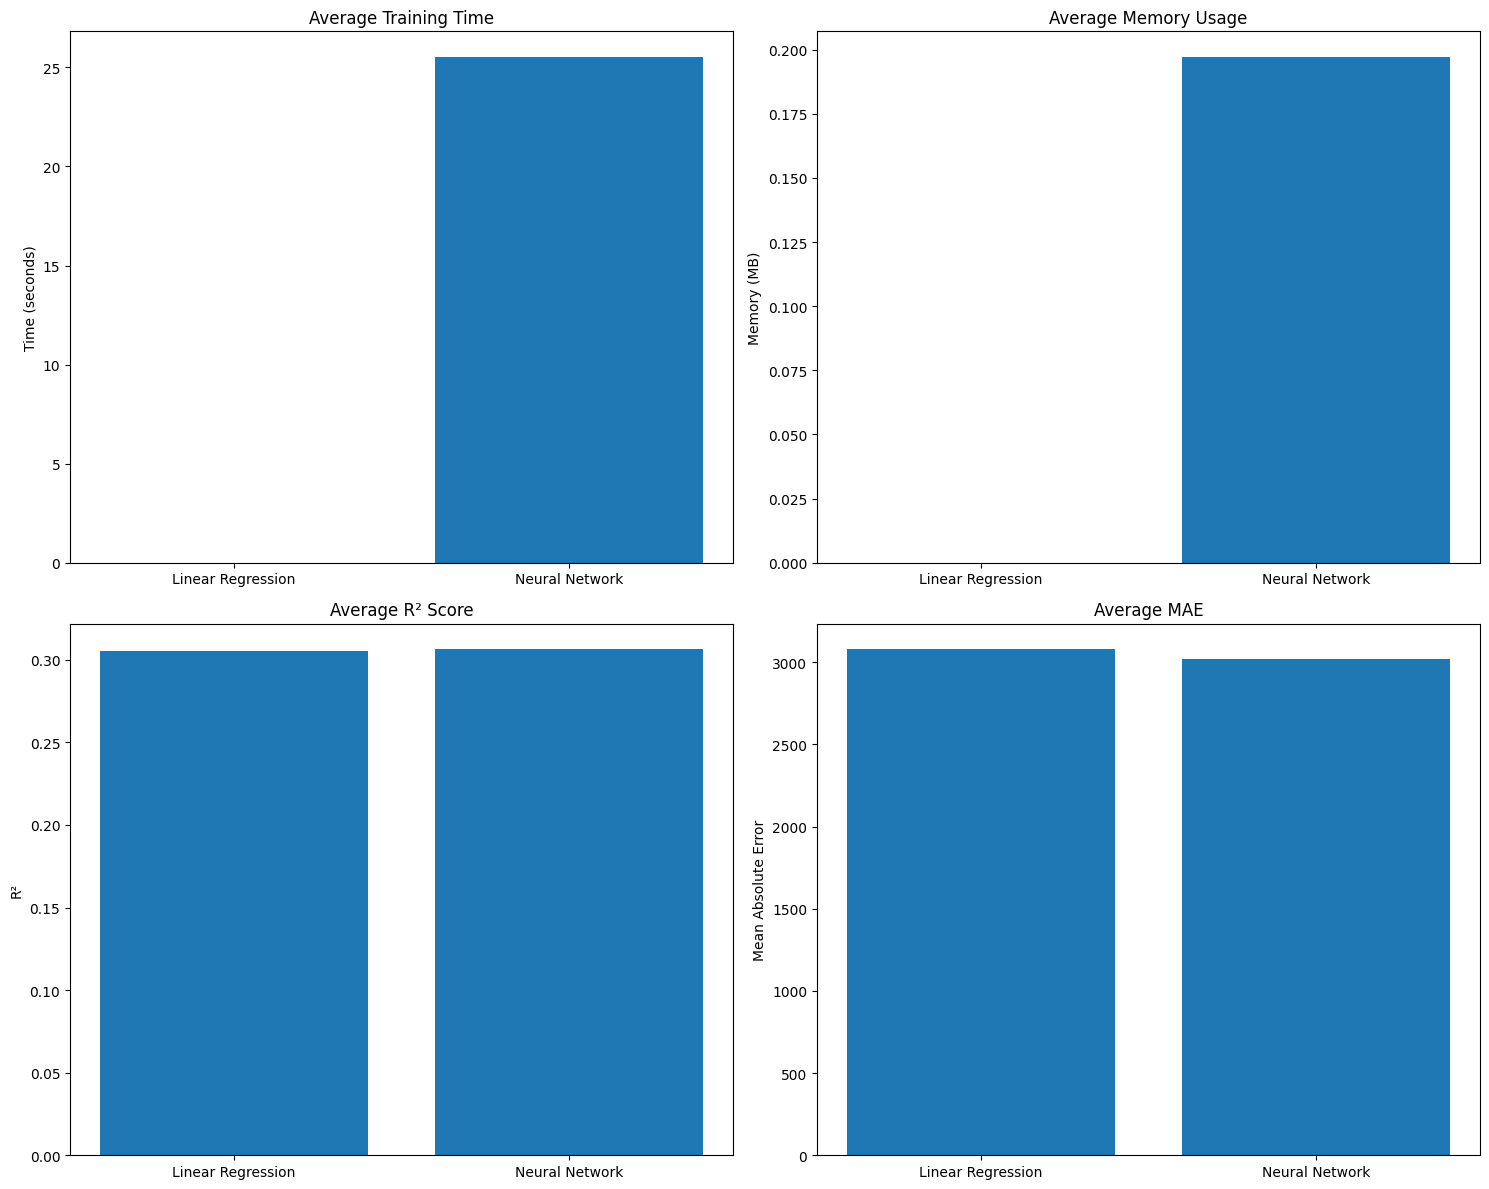

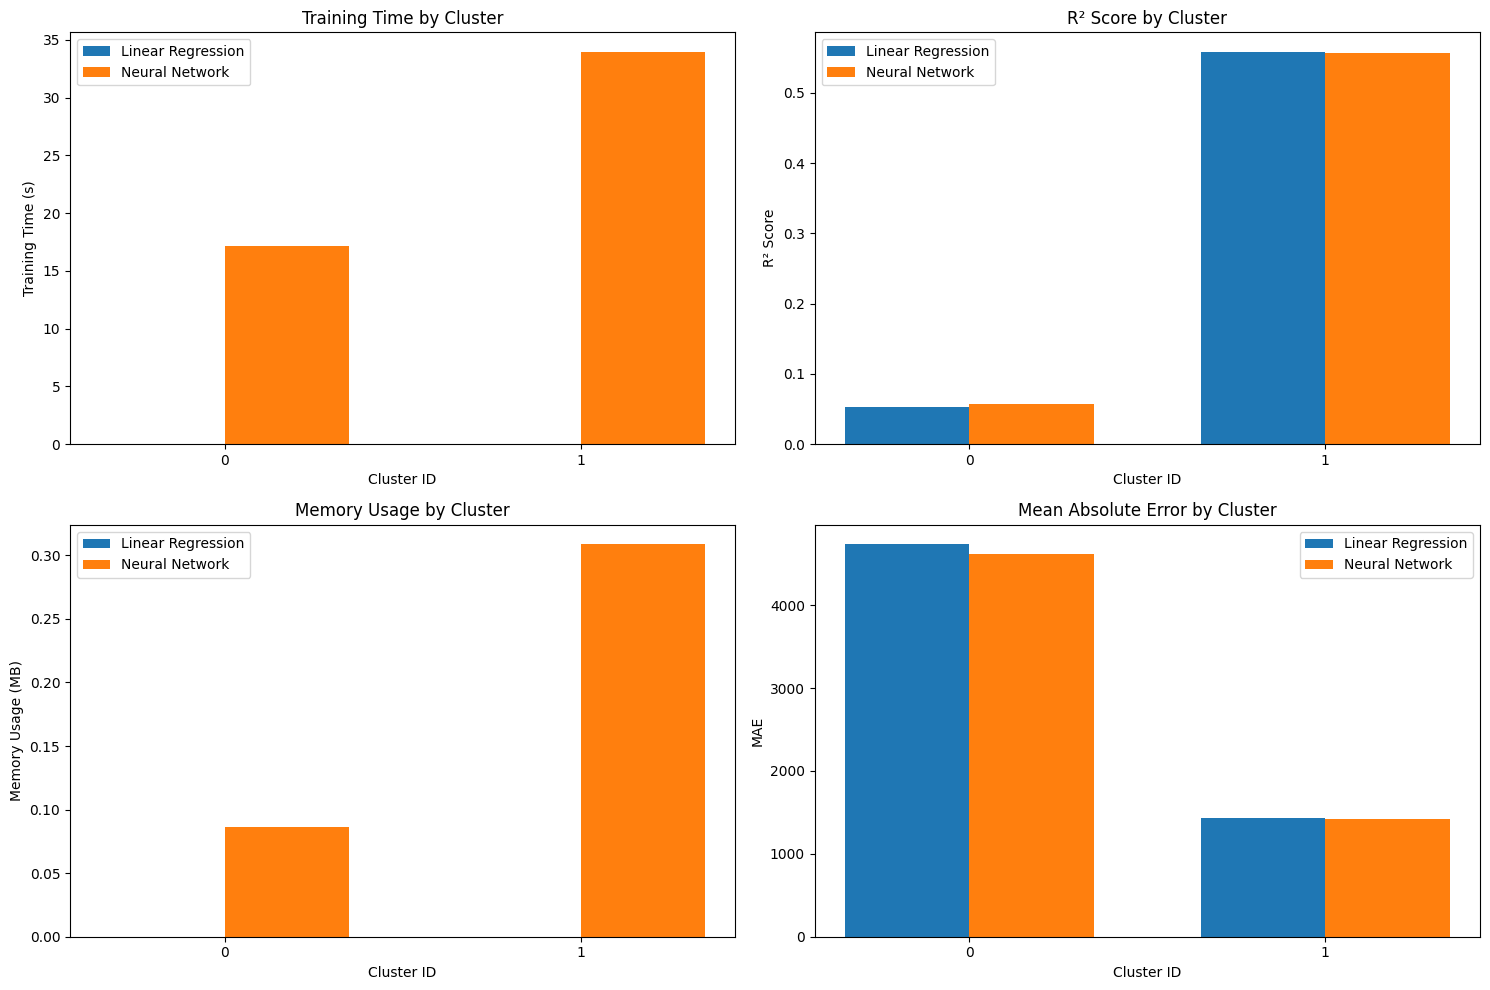


=== PERFORMANCE RECOMMENDATION ===
Neural Network requires 51001.13x more training time than Linear Regression
Neural Network provides 0.0009 absolute improvement in R² score
RECOMMENDATION: Linear Regression provides the best accuracy/performance tradeoff


In [30]:
torch.manual_seed(seed_value)
#resource monitoring
def get_process_metrics():
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / (1024 * 1024)  #MB conversion
    cpu_percent = process.cpu_percent(interval=None)
    return memory_usage, cpu_percent

# Function to log performance metrics
def log_performance(description, start_time, end_time, start_memory, end_memory, start_cpu, end_cpu):
    execution_time = end_time - start_time
    memory_increase = end_memory - start_memory
    print(f"\n----- Performance Metrics: {description} -----")
    print(f"Execution Time: {execution_time:.4f} seconds")
    print(f"Memory Usage: {start_memory:.2f} MB → {end_memory:.2f} MB (Increase: {memory_increase:.2f} MB)")
    print("-" * 50)

# Network Definition
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, final_activation='leaky_relu'):
        super(FeedForwardNN, self).__init__()
        # First linear layer
        self.fc1 = nn.Linear(input_dim, 64)
        # Second linear layer
        self.fc2 = nn.Linear(64, 32)
        # Third linear layer
        self.fc3 = nn.Linear(32, 1)
        # Activation function after first layer
        self.first_activation = nn.LeakyReLU(0.1)
        # Custom activ - chosen later
        if final_activation.lower() == 'leaky_relu':
            self.final_activation = nn.LeakyReLU(0.1)
        elif final_activation.lower() == 'prelu':
            self.final_activation = nn.PReLU()
        elif final_activation.lower() == 'gelu':
            self.final_activation = nn.GELU()
        elif final_activation.lower() == 'softplus':
            self.final_activation = nn.Softplus()
        else:
            self.final_activation = nn.ReLU()  # Default to ReLU
        # Dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.first_activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.final_activation(x)
        return x

# Performance tracking
performance_data = {
    "cluster_id": [],
    "model_type": [],
    "training_time": [],
    "inference_time": [],
    "peak_memory_usage": [],
    "avg_cpu_usage": [],
    "epochs_completed": [],
    "mae": [],
    "mse": [],
    "mape": [],
    "r2": []
}

overall_start_time = time.time()
initial_memory, initial_cpu = get_process_metrics()

# Training and Evaluation
nn_results = {}
lr_results = {}

for cluster_id in range(optimal_k):
    print(f"\n--- Processing Cluster {cluster_id} ---")
    
    train_cluster = train_clusters.get(f"Train_Cluster_{cluster_id}")
    test_cluster = test_clusters.get(f"Test_Cluster_{cluster_id}")
    
    if train_cluster is None or test_cluster is None or train_cluster.shape[0] < 5 or test_cluster.shape[0] < 1:
        print(f"Skipping Cluster {cluster_id} (Insufficient data).")
        continue
    
    feature_cols = ['liczba_pokoi', 'metrage', 'lift_encoded', 'standard_encoded', 'rating', 'cena_wwa', 'price_per_sqm_loc']
    target_col = 'PPMS'
    
    # Data preparation for neural network
    nn_scaler = MinMaxScaler()
    X_train_nn = nn_scaler.fit_transform(train_cluster[feature_cols])
    X_test_nn = nn_scaler.transform(test_cluster[feature_cols])
    X_train = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train = torch.tensor(train_cluster[target_col].values, dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test = torch.tensor(test_cluster[target_col].values, dtype=torch.float32).view(-1, 1)
    
    # Data for lin. reg.
    X_train_np = train_cluster[feature_cols].values
    y_train_np = train_cluster[target_col].values
    X_test_np = test_cluster[feature_cols].values
    y_test_np = test_cluster[target_col].values
    
    # Linear Regression Model
    print(f"\n--- Training Linear Regression for Cluster {cluster_id} ---")
    lr_start_time = time.time()
    lr_start_memory, lr_start_cpu = get_process_metrics()
    lr_model = LinearRegression()
    lr_model.fit(X_train_np, y_train_np)
    lr_train_end_time = time.time()
    lr_train_memory, lr_train_cpu = get_process_metrics()
    lr_pred = lr_model.predict(X_test_np)
    lr_end_time = time.time()
    lr_end_memory, lr_end_cpu = get_process_metrics()
    
    lr_mae = mean_absolute_error(y_test_np, lr_pred)
    lr_mse = mean_squared_error(y_test_np, lr_pred)
    lr_mape = np.mean(np.abs((y_test_np - lr_pred) / y_test_np)) * 100
    lr_r2 = r2_score(y_test_np, lr_pred)
    
    lr_results[f"Cluster {cluster_id}"] = {
        "MAE": lr_mae,
        "MSE": lr_mse,
        "MAPE (%)": lr_mape,
        "R² Score": lr_r2
    }
    
    lr_training_time = lr_train_end_time - lr_start_time
    lr_inference_time = lr_end_time - lr_train_end_time
    lr_memory_usage = lr_end_memory - lr_start_memory
    
    performance_data["cluster_id"].append(cluster_id)
    performance_data["model_type"].append("Linear Regression")
    performance_data["training_time"].append(lr_training_time)
    performance_data["inference_time"].append(lr_inference_time)
    performance_data["peak_memory_usage"].append(lr_memory_usage)
    performance_data["avg_cpu_usage"].append((lr_start_cpu + lr_end_cpu) / 2)
    performance_data["epochs_completed"].append(1)  # LR has no epochs
    performance_data["mae"].append(lr_mae)
    performance_data["mse"].append(lr_mse)
    performance_data["mape"].append(lr_mape)
    performance_data["r2"].append(lr_r2)
    
    print(f"Linear Regression Evaluation Metrics for Cluster {cluster_id}:")
    print(f"  MAE: {lr_mae:.4f}")
    print(f"  MSE: {lr_mse:.4f}")
    print(f"  MAPE: {lr_mape:.2f}%")
    print(f"  R² Score: {lr_r2:.4f}")
    log_performance(f"Linear Regression (Cluster {cluster_id})", 
                   lr_start_time, lr_end_time, 
                   lr_start_memory, lr_end_memory, 
                   lr_start_cpu, lr_end_cpu)
    
    # Neural network model
    # Different activation functions
    model_5580 = FeedForwardNN(input_dim=7, final_activation='leaky_relu')
    model = FeedForwardNN(input_dim=7, final_activation='prelu')
    model_5580  = FeedForwardNN(input_dim=7, final_activation='gelu')
    model_5580   = FeedForwardNN(input_dim=7, final_activation='softplus')

    #loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\n--- Training Feed Forward Neural Network for Cluster {cluster_id} ---")
    nn_start_time = time.time()
    nn_start_memory, nn_start_cpu = get_process_metrics()
    
    training_loss = []
    cpu_usage = []       
    memory_usage = []
    epoch_times = []
    
    patience = 5000
    best_loss = float('inf')
    counter = 0 
    epochs = 50000  # large to plot nicely, should be lowered for actual training
    last_completed_epoch = 0
    
    # Early stopping
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = criterion(predictions, y_train)
        loss.backward()
        optimizer.step()
        epoch_end = time.time()
        current_memory, current_cpu = get_process_metrics()
        
        training_loss.append(loss.item())
        cpu_usage.append(current_cpu)
        memory_usage.append(current_memory)
        epoch_times.append(epoch_end - epoch_start)
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            counter = 0
            best_model = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model)
                last_completed_epoch = epoch + 1
                break
        
        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Cluster {cluster_id} - Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
            print(f"  Epoch Time: {epoch_times[-1]:.4f}s, Memory: {current_memory:.2f}MB")
    # best model
    if last_completed_epoch == 0:
        last_completed_epoch = epochs
    torch.save(best_model, f"best_model_cluster_{cluster_id}.pt")
    
    nn_train_end_time = time.time()
    nn_train_memory, nn_train_cpu = get_process_metrics()
    
    print(f"Finished training for Cluster {cluster_id}. Evaluating the model...\n")
    # evaluation etc.
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        y_true = y_test.numpy()
    
    nn_end_time = time.time()
    nn_end_memory, nn_end_cpu = get_process_metrics()
    
    nn_mae = mean_absolute_error(y_true, y_pred)
    nn_mse = mean_squared_error(y_true, y_pred)
    nn_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    nn_r2 = r2_score(y_true, y_pred)
    
    nn_results[f"Cluster {cluster_id}"] = {
        "MAE": nn_mae,
        "MSE": nn_mse,
        "MAPE (%)": nn_mape,
        "R² Score": nn_r2
    }
    
    nn_training_time = nn_train_end_time - nn_start_time
    nn_inference_time = nn_end_time - nn_train_end_time
    nn_memory_usage = nn_end_memory - nn_start_memory
    
    performance_data["cluster_id"].append(cluster_id)
    performance_data["model_type"].append("Neural Network")
    performance_data["training_time"].append(nn_training_time)
    performance_data["inference_time"].append(nn_inference_time)
    performance_data["peak_memory_usage"].append(nn_memory_usage)
    performance_data["avg_cpu_usage"].append(np.mean(cpu_usage))
    performance_data["epochs_completed"].append(last_completed_epoch)
    performance_data["mae"].append(nn_mae)
    performance_data["mse"].append(nn_mse)
    performance_data["mape"].append(nn_mape)
    performance_data["r2"].append(nn_r2)
    
    print(f"Neural Network Evaluation Metrics for Cluster {cluster_id}:")
    print(f"  MAE: {nn_mae:.4f}")
    print(f"  MSE: {nn_mse:.4f}")
    print(f"  MAPE: {nn_mape:.2f}%")
    print(f"  R² Score: {nn_r2:.4f}")
    log_performance(f"Neural Network (Cluster {cluster_id})", 
                   nn_start_time, nn_end_time, 
                   nn_start_memory, nn_end_memory, 
                   nn_start_cpu, nn_end_cpu)
    
    print(f"Model Comparison for Cluster {cluster_id}:")
    print(f"  Linear Regression MAE: {lr_mae:.4f} vs Neural Network MAE: {nn_mae:.4f}")
    print(f"  Linear Regression MSE: {lr_mse:.4f} vs Neural Network MSE: {nn_mse:.4f}")
    print(f"  Linear Regression MAPE: {lr_mape:.2f}% vs Neural Network MAPE: {nn_mape:.2f}%")
    print(f"  Linear Regression R²: {lr_r2:.4f} vs Neural Network R²: {nn_r2:.4f}")
    print(f"  Training Time: LR {lr_training_time:.4f}s vs NN {nn_training_time:.4f}s")
    print(f"  Inference Time: LR {lr_inference_time:.4f}s vs NN {nn_inference_time:.4f}s")
    print(f"  Memory Usage: LR {lr_memory_usage:.2f}MB vs NN {nn_memory_usage:.2f}MB\n")
    
    # Plots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Loss 
    axs[0].plot(training_loss)
    axs[0].set_title(f'Cluster {cluster_id} - Training Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    
    # Memory usage 
    axs[1].plot(memory_usage)
    axs[1].set_title(f'Cluster {cluster_id} - Memory Usage')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Memory (MB)')
    
    # Epoch time 
    axs[2].plot(epoch_times)
    axs[2].set_title(f'Cluster {cluster_id} - Epoch Duration')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Time (s)')
    
    plt.tight_layout()
    plt.show()

# Performance statistics overall
overall_end_time = time.time()
final_memory, final_cpu = get_process_metrics()
log_performance("OVERALL EXECUTION", overall_start_time, overall_end_time, initial_memory, final_memory, start_cpu, end_cpu)

# Results summary
print("\n=== MODEL COMPARISON: LINEAR REGRESSION VS NEURAL NETWORK ===")
avg_lr_metrics = {"MAE": 0, "MSE": 0, "MAPE (%)": 0, "R² Score": 0}
avg_nn_metrics = {"MAE": 0, "MSE": 0, "MAPE (%)": 0, "R² Score": 0}

for cluster in lr_results:
    for metric, value in lr_results[cluster].items():
        avg_lr_metrics[metric] += value
        
for cluster in nn_results:
    for metric, value in nn_results[cluster].items():
        avg_nn_metrics[metric] += value

num_clusters = len(lr_results)
if num_clusters > 0:
    for metric in avg_lr_metrics:
        avg_lr_metrics[metric] /= num_clusters
        avg_nn_metrics[metric] /= num_clusters

print("\n--- Linear Regression Average Metrics Across All Clusters ---")
for metric, value in avg_lr_metrics.items():
    print(f"  Average {metric}: {value:.4f}")

print("\n--- Neural Network Average Metrics Across All Clusters ---")
for metric, value in avg_nn_metrics.items():
    print(f"  Average {metric}: {value:.4f}")

perf_improvement = {}
for metric in avg_lr_metrics:
    if metric == "R² Score":
        perf_improvement[metric] = ((avg_nn_metrics[metric] - avg_lr_metrics[metric]) / abs(avg_lr_metrics[metric])) * 100
    else:
        perf_improvement[metric] = ((avg_lr_metrics[metric] - avg_nn_metrics[metric]) / avg_lr_metrics[metric]) * 100

print("\n--- Performance Improvement (Neural Network vs Linear Regression) ---")
for metric, improvement in perf_improvement.items():
    if metric == "R² Score":
        print(f"  {metric}: {improvement:.2f}% {'improvement' if improvement > 0 else 'decrease'}")
    else:
        print(f"  {metric}: {improvement:.2f}% {'reduction' if improvement > 0 else 'increase'}")

# Performance comparison
perf_df = pd.DataFrame(performance_data)
print("\n=== DETAILED PERFORMANCE COMPARISON ===")
summary = perf_df.groupby('model_type').agg({
    'training_time': ['mean', 'min', 'max'],
    'inference_time': ['mean', 'min', 'max'],
    'peak_memory_usage': ['mean', 'min', 'max'],
    'avg_cpu_usage': ['mean', 'min', 'max'],
    'mae': ['mean', 'min', 'max'],
    'mse': ['mean', 'min', 'max'],
    'mape': ['mean', 'min', 'max'],
    'r2': ['mean', 'min', 'max']
}).round(4)
print(summary)

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.bar(['Linear Regression', 'Neural Network'], 
        [perf_df[perf_df['model_type'] == 'Linear Regression']['training_time'].mean(),
         perf_df[perf_df['model_type'] == 'Neural Network']['training_time'].mean()])
plt.title('Average Training Time')
plt.ylabel('Time (seconds)')

plt.subplot(2, 2, 2)
plt.bar(['Linear Regression', 'Neural Network'], 
        [perf_df[perf_df['model_type'] == 'Linear Regression']['peak_memory_usage'].mean(),
         perf_df[perf_df['model_type'] == 'Neural Network']['peak_memory_usage'].mean()])
plt.title('Average Memory Usage')
plt.ylabel('Memory (MB)')

plt.subplot(2, 2, 3)
plt.bar(['Linear Regression', 'Neural Network'], 
        [perf_df[perf_df['model_type'] == 'Linear Regression']['r2'].mean(),
         perf_df[perf_df['model_type'] == 'Neural Network']['r2'].mean()])
plt.title('Average R² Score')
plt.ylabel('R²')

plt.subplot(2, 2, 4)
plt.bar(['Linear Regression', 'Neural Network'], 
        [perf_df[perf_df['model_type'] == 'Linear Regression']['mae'].mean(),
         perf_df[perf_df['model_type'] == 'Neural Network']['mae'].mean()])
plt.title('Average MAE')
plt.ylabel('Mean Absolute Error')

plt.tight_layout()
plt.show()

cluster_ids = perf_df['cluster_id'].unique()
plt.figure(figsize=(15, 10))
x = np.arange(len(cluster_ids))
width = 0.35

plt.subplot(2, 2, 1)
lr_times = [perf_df[(perf_df['model_type'] == 'Linear Regression') & (perf_df['cluster_id'] == cid)]['training_time'].values[0] 
            for cid in cluster_ids]
nn_times = [perf_df[(perf_df['model_type'] == 'Neural Network') & (perf_df['cluster_id'] == cid)]['training_time'].values[0] 
            for cid in cluster_ids]
plt.bar(x - width/2, lr_times, width, label='Linear Regression')
plt.bar(x + width/2, nn_times, width, label='Neural Network')
plt.xlabel('Cluster ID')
plt.ylabel('Training Time (s)')
plt.title('Training Time by Cluster')
plt.xticks(x, cluster_ids)
plt.legend()

plt.subplot(2, 2, 2)
lr_r2 = [perf_df[(perf_df['model_type'] == 'Linear Regression') & (perf_df['cluster_id'] == cid)]['r2'].values[0] 
         for cid in cluster_ids]
nn_r2 = [perf_df[(perf_df['model_type'] == 'Neural Network') & (perf_df['cluster_id'] == cid)]['r2'].values[0] 
         for cid in cluster_ids]
plt.bar(x - width/2, lr_r2, width, label='Linear Regression')
plt.bar(x + width/2, nn_r2, width, label='Neural Network')
plt.xlabel('Cluster ID')
plt.ylabel('R² Score')
plt.title('R² Score by Cluster')
plt.xticks(x, cluster_ids)
plt.legend()

plt.subplot(2, 2, 3)
lr_mem = [perf_df[(perf_df['model_type'] == 'Linear Regression') & (perf_df['cluster_id'] == cid)]['peak_memory_usage'].values[0] 
          for cid in cluster_ids]
nn_mem = [perf_df[(perf_df['model_type'] == 'Neural Network') & (perf_df['cluster_id'] == cid)]['peak_memory_usage'].values[0] 
          for cid in cluster_ids]
plt.bar(x - width/2, lr_mem, width, label='Linear Regression')
plt.bar(x + width/2, nn_mem, width, label='Neural Network')
plt.xlabel('Cluster ID')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage by Cluster')
plt.xticks(x, cluster_ids)
plt.legend()

plt.subplot(2, 2, 4)
lr_mae = [perf_df[(perf_df['model_type'] == 'Linear Regression') & (perf_df['cluster_id'] == cid)]['mae'].values[0] 
          for cid in cluster_ids]
nn_mae = [perf_df[(perf_df['model_type'] == 'Neural Network') & (perf_df['cluster_id'] == cid)]['mae'].values[0] 
          for cid in cluster_ids]
plt.bar(x - width/2, lr_mae, width, label='Linear Regression')
plt.bar(x + width/2, nn_mae, width, label='Neural Network')
plt.xlabel('Cluster ID')
plt.ylabel('MAE')
plt.title('Mean Absolute Error by Cluster')
plt.xticks(x, cluster_ids)
plt.legend()

plt.tight_layout()
plt.show()

# Recommendation - for personal use, not in the report
print("\n=== PERFORMANCE RECOMMENDATION ===")
avg_lr_time = perf_df[perf_df['model_type'] == 'Linear Regression']['training_time'].mean()
avg_nn_time = perf_df[perf_df['model_type'] == 'Neural Network']['training_time'].mean()
time_ratio = avg_nn_time / avg_lr_time
avg_lr_r2 = perf_df[perf_df['model_type'] == 'Linear Regression']['r2'].mean()
avg_nn_r2 = perf_df[perf_df['model_type'] == 'Neural Network']['r2'].mean()
accuracy_diff = avg_nn_r2 - avg_lr_r2
print(f"Neural Network requires {time_ratio:.2f}x more training time than Linear Regression")
print(f"Neural Network provides {accuracy_diff:.4f} absolute improvement in R² score")

# for person reading this - not in the report, personal thoughts

if accuracy_diff > 0.05 and time_ratio < 100:
    print("RECOMMENDATION: Consider using Neural Networks for better accuracy")
elif accuracy_diff > 0.02 and time_ratio < 10:
    print("RECOMMENDATION: Neural Networks provide modest gains with reasonable computational cost")
else:
    print("RECOMMENDATION: Linear Regression provides the best accuracy/performance tradeoff")


Load manually provided real estate features into a DataFrame. Classify the input using the KMeans clustering model based on selected features (PPMS, metrage, rating). Scale the data using the MinMaxScaler and predict the cluster. Load the corresponding pre-trained Neural Network model, if available, and perform inference to estimate the price per square meter (PPMS). Display the predicted price, or notify if the model file is missing. - for specific pricing

In [31]:
# features of a specific flat
manual_features = {
    "liczba_pokoi": 2,
    "metrage": 46,
    "lift_encoded": 1,         # 1 if lift present, 0 otherwise
    "standard_encoded": 1,     # 1 if condition "do wykonczenia", else 0
    "rating": 0.001994295,
    "cena_wwa": 15504.43164,        # price in Warsaw \
    "price_per_sqm_loc": 22210.838  # district based price per sqm
}
# conversion to DataFrame
input_df = pd.DataFrame([manual_features])
print("Manual Input Features:")
print(input_df)

# clustering, 0 as dummy because it is predicted 
if "PPMS" not in input_df.columns:
    input_df["PPMS"] = 0

# Clustering scaler
input_for_cluster = scaler.transform(input_df[['PPMS', 'metrage', 'rating']])
#zero indexed cluster
predicted_cluster = int(kmeans.predict(input_for_cluster)[0])
print(f"\nPredicted Cluster (zero-indexed): {predicted_cluster}")

# Min max for Neural network
input_nn = nn_scaler.transform(input_df[["liczba_pokoi", "metrage", "lift_encoded", 
                                          "standard_encoded", "rating", "cena_wwa", "price_per_sqm_loc"]])
input_nn_tensor = torch.tensor(input_nn, dtype=torch.float32)

# Saved model
model_path = f"best_model_cluster_{predicted_cluster}.pt"
if os.path.exists(model_path):
    loaded_model = FeedForwardNN(input_dim=7, final_activation='prelu')  # instantiate with same architecture - manual 
    loaded_model.load_state_dict(torch.load(model_path))

    loaded_model.eval()
    
    # Prediciton
    with torch.no_grad():
        predicted_ppms = loaded_model(input_nn_tensor).item()
    
    print(f"\nPrediction for PPMS using model for Cluster {predicted_cluster}: {predicted_ppms:.4f}")
else:
    print(f"\nSaved model file '{model_path}' not found. Please ensure the model for Cluster {predicted_cluster} is saved.")


Manual Input Features:
   liczba_pokoi  metrage  lift_encoded  standard_encoded    rating  \
0             2       46             1                 1  0.001994   

      cena_wwa  price_per_sqm_loc  
0  15504.43164          22210.838  

Predicted Cluster (zero-indexed): 1

Prediction for PPMS using model for Cluster 1: 19213.3965
